# DIA Analysis: Supernovae from the Run 1.2p Test
Michael Wood-Vasey
Last Verified to Run: 2019-07-06

After completing this Notebook, the user will be able to
1. Get a list of simulated SN from the Run 1.2p truth catalog
2. Select SNe within the test patch in the Run 1.2p DIA Test
3. Plot lightcurves from the DIA analysis
4. Plot lightcurves from the truth catalog
5. Compare the input and recovered lightcurves.

See the Truth GCR Variables for a basic overview of the Truth information and how to access it for variables.
https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/truth_gcr_variables.ipynb

In [1]:
# Inject gcr-catalogs that supports DIA source into path.
import os
import math
import sys

import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
# Requires issues/337 to fix obshistid query.
sys.path.insert(0, '/global/homes/w/wmwv/local/lsst/gcr-catalogs')

In [3]:
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
from lsst.daf.persistence import Butler
from lsst.geom import SpherePoint
import lsst.geom

In [4]:
import GCRCatalogs

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [6]:
repo = '/global/cscratch1/sd/rearmstr/new_templates/diffim_template'

In [7]:
butler = Butler(repo)

In [8]:
diaSrc = GCRCatalogs.load_catalog('dc2_dia_source_run1.2p_test')
diaObject = GCRCatalogs.load_catalog('dc2_dia_object_run1.2p_test')
truth_cat = GCRCatalogs.load_catalog('dc2_truth_run1.2_variable_summary')
truth_lc = GCRCatalogs.load_catalog('dc2_truth_run1.2_variable_lightcurve')

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/GCR/base.py:373: UserWarning: Native quantity `psFluxMean_{band}` does not exist (required by `magMeanErr_i`, `magMeanErr_z`, `magMeanErr_r`, `magMeanErr_y`, `magMeanErr_u`, `magMeanErr_g`)
  warnings.warn(msg)


(We presently will get a warning from the catalog reader in the initalization above because there is no u-band in the subtractions.)

## Select SNe from the truth catalog

In [9]:
columns = ['ra', 'dec', 'redshift', 'uniqueId', 'galaxy_id', 'sn']
truth_all_sne = pd.DataFrame(truth_cat.get_quantities(columns, filters=[f'sn == 1']))

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


You'll get a dataset.value deprecation warning.  Don't worry about this.  The Data Access Team will fix this someday.

In [10]:
print(f'We found {len(truth_all_sne)} simulated SNe.')

We found 76689 simulated SNe.


## Select SNe from the truth catalog in the DIA test region

In [11]:
tract = 4849
patch = (6, 6)

In [12]:
skymap = butler.get('deepCoadd_skyMap')
tract_info = skymap[tract]

In [13]:
foo = tract_info.getPatchInfo(patch)

In [14]:
bar = foo.getOuterSkyPolygon(tract_info.getWcs())

In [15]:
tract_box = afwGeom.Box2D(tract_info.getBBox())
tract_pos_list = tract_box.getCorners()
wcs = tract_info.getWcs()
corners = wcs.pixelToSky(tract_pos_list)
corners = np.array([[c.getRa().asDegrees(), c.getDec().asDegrees()] for c in corners])

In [16]:
print(corners)

[[ 54.72776196 -29.78294629]
 [ 52.93572545 -29.78294586]
 [ 52.949112   -28.22767319]
 [ 54.71437636 -28.2276736 ]]


In [17]:
ra = corners[:, 0]
dec = corners[:, 1]
min_ra, max_ra = np.min(ra), np.max(ra)
min_dec, max_dec = np.min(dec), np.max(dec)

In [18]:
area_cut = [f'ra > {min_ra}', f'ra < {max_ra}', f'dec > {min_dec}', f'dec < {max_dec}']
sn_cut = ['sn == 1']
all_cuts = area_cut + sn_cut

In [19]:
columns = ['ra', 'dec', 'redshift', 'uniqueId', 'galaxy_id', 'sn']
truth_sne = pd.DataFrame(truth_cat.get_quantities(columns, filters=all_cuts))

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [20]:
print(f'We found {len(truth_sne)} simulated SNe.')

We found 8508 simulated SNe.


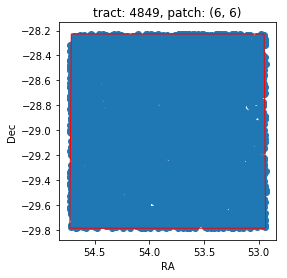

In [21]:
avg_dec = (min_dec + max_dec)/2
size = 8
dec_size = size
ra_size = dec_size * np.cos(np.deg2rad(avg_dec))
aspect_ratio = dec_size / ra_size

# fig = plt.figure(figsize=(size, size))
ax = plt.gca()
ax.set_aspect(aspect_ratio)

patch_region = Polygon(corners, color='red', fill=False)

ax.scatter(truth_sne['ra'], truth_sne['dec'])
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_xlim(plt.xlim()[::-1])
ax.add_patch(patch_region);
ax.set_title(f'tract: {tract}, patch: {patch}');

## A Lightcurve

Search for diaObjects that match input simulated SNe.

In [22]:
i = 0
sn = truth_sne.iloc[0]

In [23]:
print(sn)

ra           5.300728e+01
uniqueId     3.082506e+14
galaxy_id    3.010259e+11
redshift     2.376888e-01
dec         -2.838755e+01
sn           1.000000e+00
Name: 0, dtype: float64


Oops, we need to fix up the `dtype`s somewhere.  Those shouldn't all be floats.

Get the lightcurve

In [24]:
columns = ['obshistid', 'mjd', 'mag', 'filter']

sn_lc = pd.DataFrame(truth_lc.get_quantities(columns,
                                             native_filters=[f'uniqueId == {sn["uniqueId"]}']))

In [25]:
sn_lc.rename(columns={'filter': 'filter_code'}, inplace=True)

In [26]:
# Translate filter codes to filter names
filter_names = ['u', 'g', 'r', 'i', 'z', 'y']
sn_lc['filter'] = [filter_names[f] for f in sn_lc['filter_code']]
sn_lc = sn_lc.sort_values('mjd')

In [27]:
def plot_lightcurve(df, plot='mag', flux_col_names=None,
                    title=None, marker='o', linestyle='none',
                    colors=None, label_prefix='',
                    **kwargs):
    """Plot a lightcurve from a DataFrame.
    """
    # At lexigraphical order, if not wavelength order.
    # Assume fixed list of filters.
    filter_order = ['u', 'g', 'r', 'i', 'z', 'y']

    if colors is None:
        colors = {'u': 'violet', 'g': 'indigo', 'r': 'blue', 'i': 'green', 'z': 'orange', 'y': 'red'}
    
    if flux_col_names is not None:
        flux_col, flux_err_col = flux_col_names
    else:
        if plot == 'flux':
            flux_col = 'psFlux'
            flux_err_col = 'psFluxErr'
        else:
            flux_col = 'mag'
            flux_err_col = 'mag_err'
        
    for filt in filter_order:
        this_filter = df.query(f'filter == "{filt}"')
        if this_filter.empty:
            continue
        # This if sequence is a little silly.
        plot_kwargs = {'linestyle': linestyle, 'marker': marker, 'color': colors[filt],
                       'label': f'{label_prefix} {filt}'}
        plot_kwargs.update(kwargs)

        if flux_err_col in this_filter.columns:
            plt.errorbar(this_filter['mjd'], this_filter[flux_col], this_filter[flux_err_col],
                         **plot_kwargs)
                        
        else:
            if marker is None:
                plt.plot(this_filter['mjd'], this_filter[flux_col], **plot_kwargs)

            else:
                plot_kwargs.pop('linestyle')
                plt.scatter(this_filter['mjd'], this_filter[flux_col], **plot_kwargs)



    plt.xlabel('MJD')

    if plot == 'flux':
        plt.ylabel('psFlux [nJy]')
    else:
        # Ensure that y-axis decreases as one goes up
        # Because plot_lightcurve could be called several times on the same axis,
        # simply inverting is not correct.  We have to reverse a sorted list.
        plt.ylim(sorted(plt.ylim(), reverse=True))
        plt.ylabel('mag [AB]')

    if title is not None:
        plt.title(title)
    plt.legend()

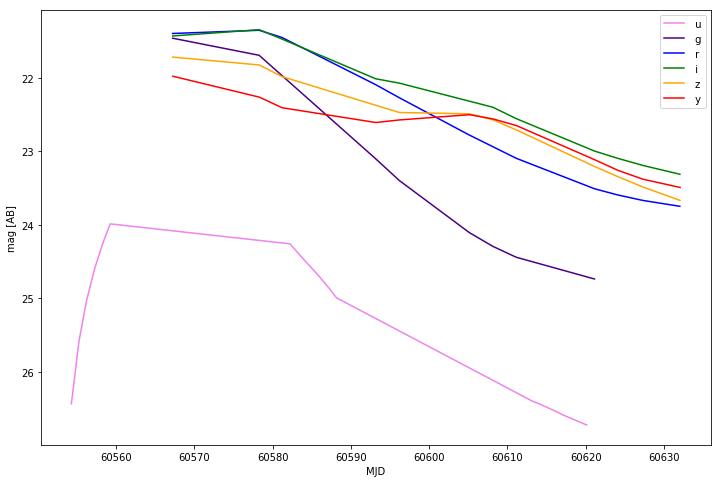

In [28]:
plt.figure(figsize=(12, 8))
plot_lightcurve(sn_lc, plot='mag', linestyle='-', marker=None)

### Match to DIAObject Catalog

In [29]:
ra, dec = sn['ra'], sn['dec']
print(ra, dec)

53.00727812651823 -28.387552632959427


In [30]:
# Match on RA, Dec
sn_position = SkyCoord(sn['ra'], sn['dec'], unit='deg')

diaObject_cat = diaObject.get_quantities(['ra', 'dec', 'diaObjectId'])
diaObject_positions = SkyCoord(diaObject_cat['ra'], diaObject_cat['dec'], unit='deg')

idx, sep2d, _ = sn_position.match_to_catalog_sky(diaObject_positions)
print(f'Index: {idx} is {sep2d.to(u.arcsec)[0]:0.6f} away')

Index: 22 is 0.028836 arcsec away


In [31]:
diaObjectId = diaObject_cat['diaObjectId'][idx]

How did we do with the lightcurve?

In [32]:
sn_lc

,mjd,mag,obshistid,filter_code,filter
0,60554.288025,26.432639,657401,0,u
1,60555.258471,25.581090,658296,0,u
2,60556.250832,25.019064,659233,0,u
3,60557.246086,24.602021,660201,0,u
4,60558.249432,24.266763,660882,0,u
5,60559.245016,23.986753,661527,0,u
6,60567.219180,21.397669,664557,2,r
7,60567.228879,21.461969,664577,1,g
8,60567.234411,21.431454,664587,3,i
9,60567.244111,21.719140,664607,4,z


In [33]:
# We can't use a direct filters = match in the GCR wrapper for the diaSrc table.
# So we have to use a lambda function here to match the ID
dia_lc = pd.DataFrame(diaSrc.get_quantities(['visit', 'mjd', 'psFlux', 'psFluxErr', 'mag', 'mag_err', 'filter'],
                                            filters=[(lambda x: x == diaObjectId, 'diaObjectId')]))
dia_lc = dia_lc.sort_values('mjd')                    

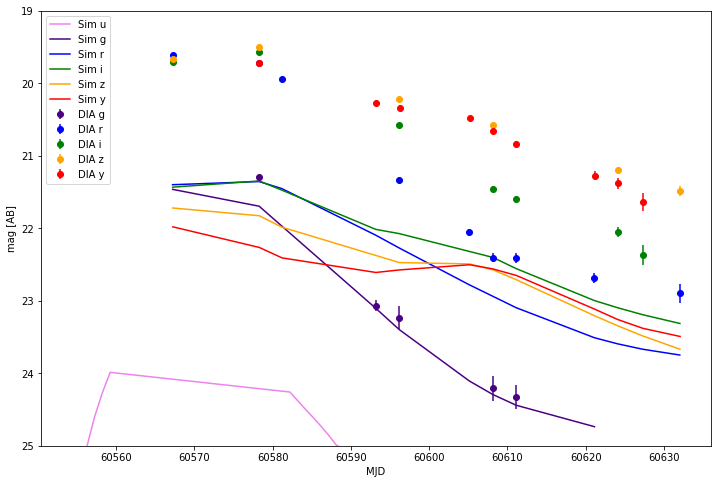

In [34]:
plt.figure(figsize=(12, 8))
plot_lightcurve(sn_lc, plot='mag', linestyle='-', marker=None, label_prefix='Sim')
plot_lightcurve(dia_lc, plot='mag', label_prefix='DIA')

sim_date_range = [min(sn_lc['mjd']), max(sn_lc['mjd'])]
sim_date_delta = sim_date_range[1] - sim_date_range[0]
buffer_fraction = 0.05
plot_date_range = sim_date_range
plot_date_range[0] -= sim_date_delta * buffer_fraction
plot_date_range[1] += sim_date_delta * buffer_fraction

plt.xlim(plot_date_range)
plt.ylim(25, 19);

The shape seems good.  But the calibration is magnitudes off.  It does look like it's a constant magnitude offset.

In [35]:
sn_lc.query('(60567 < mjd) & (mjd < 60568)')

,mjd,mag,obshistid,filter_code,filter
6,60567.219180,21.397669,664557,2,r
7,60567.228879,21.461969,664577,1,g
8,60567.234411,21.431454,664587,3,i
9,60567.244111,21.719140,664607,4,z
10,60567.256310,21.978863,664633,5,y


In [36]:
dia_lc.query('(60567 < mjd) & (mjd < 60568)')

,mjd,psFlux,mag_err,psFluxErr,visit,mag,filter
5,60567.219782,51954.298318,0.009033,430.379216,664557,19.610946,r
6,60567.235013,47920.015598,0.010489,461.672183,664587,19.698708,i
7,60567.244713,49375.749296,0.012521,568.633628,664607,19.666216,z


The MJD for the same visits (recall `visit` == `obshistid`) are slightly different between the truth catalog and the DIA lightcurve:

In [37]:
(60567.219180 - 60567.219782) * 24 * 3600

-52.0128000061959

Why the 52 second difference?

Let's match on `obshistid == visit` to get a matched set of dataframes that we can compare.

In [38]:
joint_lc = pd.merge(sn_lc, dia_lc, left_on='obshistid', right_on='visit', suffixes=('_sim', '_dia'))

In [39]:
joint_lc['mjd'] = joint_lc['mjd_dia']
joint_lc['filter'] = joint_lc['filter_sim']
joint_lc['delta_mag'] = joint_lc['mag_dia'] - joint_lc['mag_sim']

In [40]:
joint_lc

,mjd_sim,mag_sim,obshistid,filter_code,filter_sim,mjd_dia,psFlux,mag_err,psFluxErr,visit,mag_dia,filter_dia,mjd,filter,delta_mag
0,60567.219180,21.397669,664557,2,r,60567.219782,51954.298318,0.009033,430.379216,664557,19.610946,r,60567.219782,r,-1.786722
1,60567.234411,21.431454,664587,3,i,60567.235013,47920.015598,0.010489,461.672183,664587,19.698708,i,60567.235013,i,-1.732747
2,60567.244111,21.719140,664607,4,z,60567.244713,49375.749296,0.012521,568.633628,664607,19.666216,z,60567.244713,z,-2.052925
3,60578.271042,21.354127,671659,2,r,60578.271644,47085.850480,0.008895,385.539974,671659,19.717774,r,60578.271644,r,-1.636353
4,60578.280324,21.694316,671678,1,g,60578.280926,10983.583655,0.020358,205.931007,671678,21.298140,g,60578.280926,g,-0.396176
5,60578.285857,21.346081,671688,3,i,60578.286459,53817.660622,0.010054,498.132297,671688,19.572688,i,60578.286459,i,-1.773393
6,60578.295556,21.825918,671708,4,z,60578.296158,57613.595367,0.012146,644.364773,671708,19.498688,z,60578.296158,z,-2.327230
7,60578.307755,22.263662,671734,5,y,60578.308357,47248.056561,0.020698,900.609948,671734,19.714040,y,60578.308357,y,-2.549622
8,60581.174302,21.450943,674105,2,r,60581.174904,38596.129793,0.011141,395.892130,674105,19.933641,r,60581.174904,r,-1.517302
9,60593.173940,23.101931,684488,1,g,60593.174542,2152.571205,0.074385,147.471570,684488,23.067606,g,60593.174542,g,-0.034324


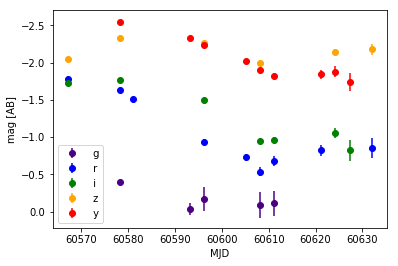

In [41]:
plot_lightcurve(joint_lc, flux_col_names=('delta_mag', 'mag_err'))

Hmmm.... so not really a constant offset in magnitude.
Nevertheless, I can only suspect there's some calibration or flux interpretation error somewhere.

If one wants to look at the postage stamps of this SN, get started with the examples in
[dia_source_object_stamp.ipynb](dia_source_object_stamp.ipynb)